## Summary of the Results

Here I compare the results obtained on the MovieLens dataset using [Xiangnan He et al, 2017](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf) implemented in `Keras` (original paper), `Pytorch` and `Gluon`.

The problem, as framed in the paper, consists in predicting whether a user "interacted" with a movie (1) or not (0), i.e. ignoring the actual movie rating. The success metrics are the Hit Ratio (HR) and Normalized Discounted Cumulative Gain (NDCG) at K, with K=10 in this excercise. For more details on the problem formulation I recommend reading the [paper](https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf). 

Moving to the code, the authors used Binary Cross-Entropy as loss, which is normally considered [slightly better](https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/) better than mean squared error. When using `Keras` this proves to be the case and the metrics are slightly better. However, when using `Pytorch` or `Gluon` I obtained slightly better results (still comparable) when using mean squared error. Therefore, the metrics shown below are obtained using `binary_crossentropy` for `Keras` and `MSE` for `Pytorch` and `Gluon`. 

In addition, for `Keras`, an `Adam` optimizer with learning rate of 0.001 works a bit better than learning rate 0.01, while better results are obtained for `Pytorch` or `Gluon` with a learning rate of 0.01 and the same optimizer. If you think of schedulers and decays, is a fair thought, maybe you would like to read [this](https://stackoverflow.com/questions/39517431/should-we-do-learningrate-decay-for-adam-optimizer).

In [1]:
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sns.set(style="darkgrid")

from plot_utils import *

warnings.filterwarnings('ignore')
%matplotlib inline

The `results_df` dataframe contains the results of all the experiments I run. These can be found in the `run_net.sh` script. 

In [2]:
results_df = results_df = pd.read_pickle("models/results_df.p")
print(results_df.shape)
results_df.head()

(82, 5)


,modelname,best_hr,best_ndcg,best_iter,train_time
0,keras_GMF_bs_256_reg_00_lr_001_n_emb_8.h5,0.649834,0.370375,16,77.156864
1,keras_GMF_bs_256_reg_00_lr_001_n_emb_16.h5,0.683940,0.402805,11,78.877995
2,keras_GMF_bs_256_reg_00_lr_001_n_emb_32.h5,0.675166,0.397736,9,81.803547
3,keras_GMF_bs_256_reg_00_lr_001_n_emb_64.h5,0.661258,0.386679,6,88.402157
4,pytorch_GMF_bs_256_lr_001_n_emb_8.pt,0.639570,0.366749,26,55.692081


For example, the first row corresponds to the General Matrix Factorization (GMF) architecture, using a batch size of 256, no regularization, a learning rate of 0.01 and 8 dimensions embeddings. 

## GMF Results

The GMF model is rather simple, user and item embeddings multiplied (no bias in the paper's implementation) and "plugged" into an output neuron with a `sigmoid` activation function.  

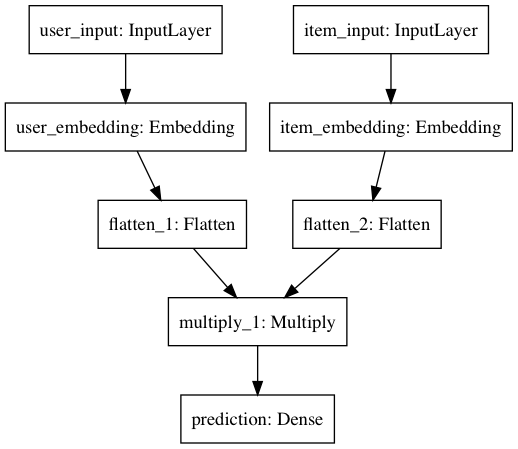

In [3]:
Image(filename = "GMF_model.png", width=300)

In [4]:
df_gmf = GMF_df(results_df)
idxmax = [df_gmf[df_gmf.dl_frame == "keras"].best_hr.idxmax(), 
          df_gmf[df_gmf.dl_frame == "pytorch"].best_hr.idxmax(),
          df_gmf[df_gmf.dl_frame == "gluon"].best_hr.idxmax()]
df_gmf.style.apply(lambda x: ['background: lightgreen' if x.name in idxmax else '' for i in x], axis=1)

,best_hr,best_ndcg,best_iter,dl_frame,n_emb
0,0.655795,0.37442,22,gluon,8
1,0.681291,0.397792,20,gluon,16
2,0.687417,0.408483,19,gluon,32
3,0.917219,0.632879,29,gluon,64
4,0.649834,0.370375,16,keras,8
5,0.686589,0.407822,25,keras,16
6,0.700166,0.420537,28,keras,32
7,0.690894,0.409264,6,keras,64
8,0.654305,0.375053,26,pytorch,8
9,0.681457,0.400793,22,pytorch,16


The first thing to notice is that the `Keras` results are consistent with those in the original paper (see their Figure 4, for the GMF model). The small differences are likely due to the fact that I run 30 epochs, while the authors run 100 (or at least this is the default number included in their repo). I often find that the model overfits quite early.   

On the other hand, and more importantly, we can see that, while the results are comparable between the tree frames for 8, 16 and 32 embeddings, both `Pytorch` and moreover `Gluon` significantly outperform `Keras` when using 64 dim embeddings. It is also worth noting that the best iteration for `Pytorch` is number 30, which suggest that the model was still learning by that iteration and that a higher number of epochs could lead to a better result.  

Overall, I would assume that the reason for such different results between the three frames is related to the optimizers, but I would need `Tensorflow`, `Pytorch` and `Gluon` experts to help me explain it. 

## MLP Results

The MLP model is also rather simple. User and Item embeddings, concatenated in a first layer and passed to a series of dense layers. Finally, the final layer is connected to an output neuron with a sigmoid activation (see the paper their Figure 2). 

It is my understanding that in the original paper they use 3 dense layer being the 1st one the result of concatenating the embeddings, as illustrated in the following figure

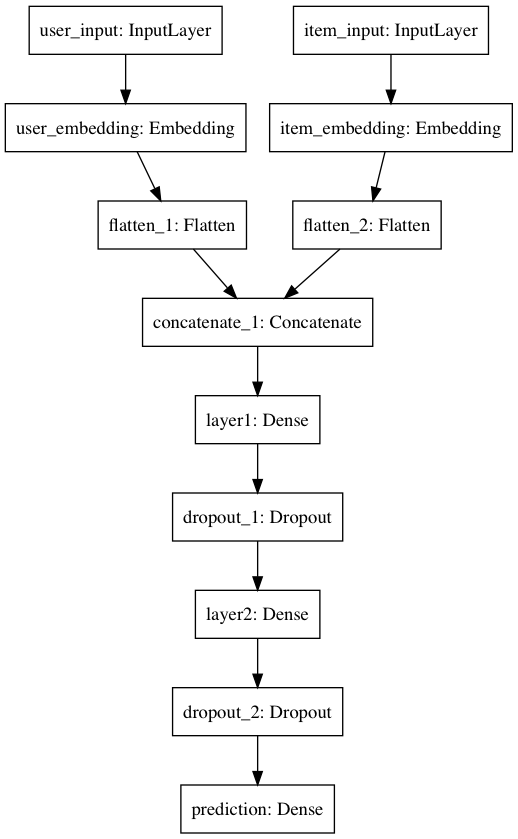

In [5]:
Image(filename = "MLP_model.png", width=300)

In [6]:
df_mlp = MLP_df(results_df)
idxmax = [df_mlp[df_mlp.dl_frame == "keras"].best_hr.idxmax(), 
          df_mlp[df_mlp.dl_frame == "pytorch"].best_hr.idxmax(),
          df_mlp[df_mlp.dl_frame == "gluon"].best_hr.idxmax()]
df_mlp.style.apply(lambda x: ['background: lightgreen' if x.name in idxmax else '' for i in x], axis=1)

,best_hr,best_ndcg,best_iter,dl_frame,n_emb,with_dropout
0,0.459603,0.251677,7,gluon,16,wodp
1,0.936093,0.578107,14,gluon,32,wodp
2,0.781126,0.542325,3,gluon,64,wdp
3,0.702152,0.514179,40,gluon,128,wdp
4,0.657616,0.382151,26,keras,16,wodp
5,0.683609,0.400878,25,keras,32,wodp
6,0.686755,0.401642,11,keras,64,wodp
7,0.703311,0.414863,32,keras,128,wdp
8,0.658775,0.38508,28,pytorch,16,wodp
9,0.674669,0.386828,40,pytorch,32,wdp


Before commenting the results in the table let me explain a bit the experiments I run which are all in the `run_net.sh` script. For the MLP I have used the following layer set ups: [32, 16, 8], "[64, 32, 16]", [128, 64, 32] and  [256, 128, 64]. This means that the number of embeddings that are concatenated in the first layer are 16, 32, 64 and 128 respectively. I also tried with and without dropout. The best results per number of embeddings and deep learning frame are shown in the table. 

Again, `Keras`'s results are consistent with those in the paper. As with the GMF, `Keras` is the most consistent frame in terms of performance as we increase the number of embeddings, with maximum `HR@10 and NDCG@10` of 0.70 and 0.41 respectively for 128 dim embeddings and dropout (of 0.25). `Gluon` shows a sharp increase from 16 to 32 embeddings reaching `HR@10` and `NDCG@10` of 0.94 and 0.58 respectively. Finally, `Pytorch` shows some consistency in terms of improving results as we increase number of embeddings, with a remarkable 0.99(!) `HR@10` (and 0.79 `NDCG@10`) when using 128 embeddings and no dropout. 

## Neural Collaborative Filtering

Here we combine the two models before as illustrated in the Figure

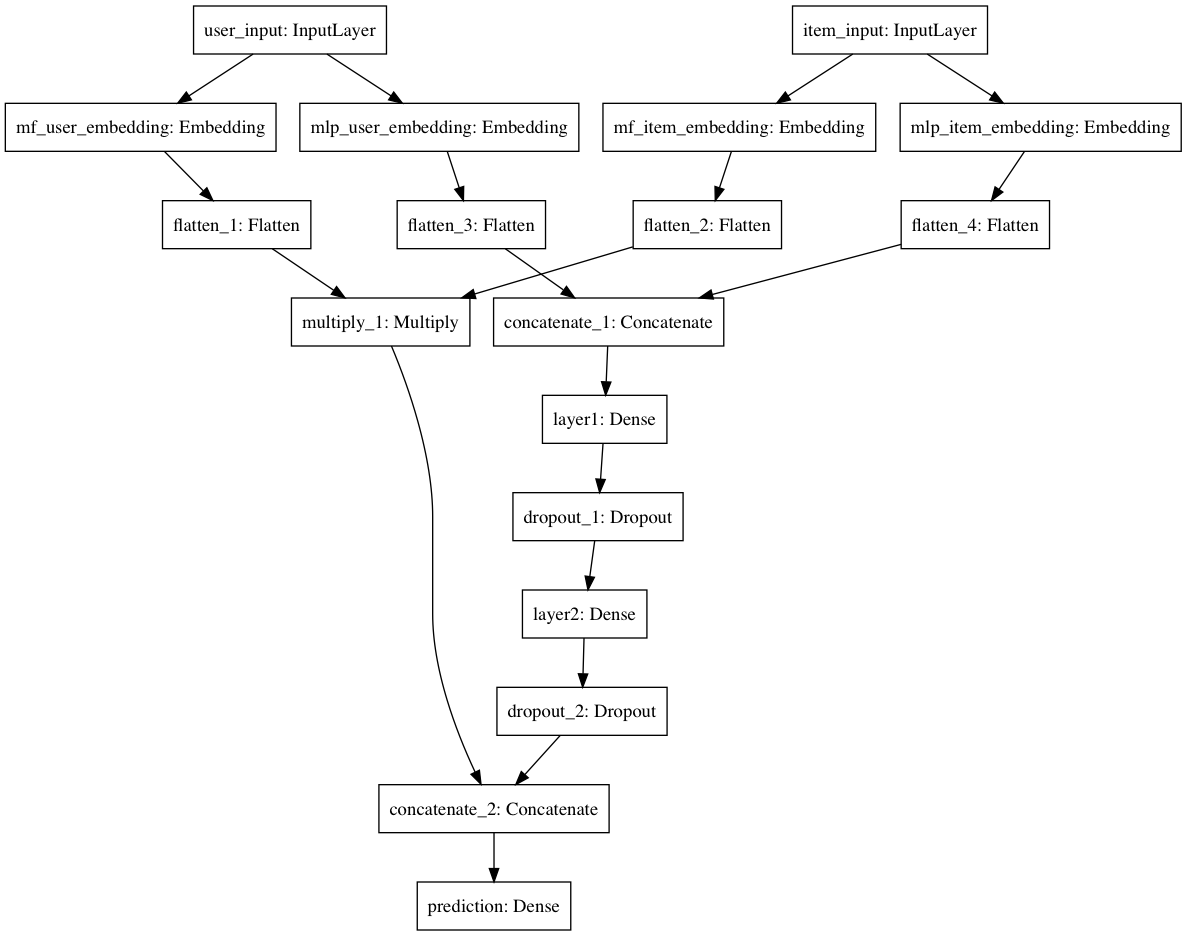

In [7]:
Image(filename = "NeuMF_model.png", width=500)

Here I have also tried a number of set ups: I have tried this architecture fully trainable, with pretrained weights and then re-trained for a small number of epochs and lower learning rate and freezing the entire architecture but the last dense layer (`concatenate_2` in the figure) then trained for a small number of epochs and lower learning rate.

On the other hand, in the paper they explain that: *"After feeding pre-trained parameters into NeuMF, we optimize it with the vanilla SGD, rather than Adam. This is because Adam needs to save momentum information for updating parameters properly. As we initialize NeuMF with pre-trained model parameters only and forgo saving the momentum information, it is unsuitable to further optimize NeuMF with momentum-based methods."*

This makes sense. However, for `Keras` I obtained almost identical results using `SGD` or `Adam` while, when using pretrained weights, I obtained significantly better results when using `Adam` in the cases of `Pytorch` and `Gluon`. Maybe the momentum is saved in these last two frames when one saves the model (?). In fact, in the case of `Gluon`, there is almost no learning when I use `SGD` and pretrained weights (note identical results in rows 1 and 2). 

Again, the experiments run when using the NeuMF model are all included in `run_net.sh`. For completion I will write them here. Note that for the two models (GMF and MLP) to have the same "weight" when combining them in the last layer of the NeuMF model, the dimensions of the last layer of the MLP side and the embeddings dimension of the GMF side must be equal. This will explain some of the combinations described below.  

**Keras**:

GMF: `n_emb=32`. Performace: `best_hr=0.70`, `best_ndcg=0.42`

MLP: `layers=[128, 64, 32]` and no dropout. Performance, `best_hr=0.69`, `best_ndcg=0.40`

**Pytorch**

GMF: `n_emb=64`. Performace: `best_hr=0.80`, `best_ndcg=0.56`

MLP: `layers=[256, 128, 64]` and no dropout. Performance, `best_hr=0.83`, `best_ndcg=0.62`

**Gluon**

GMF: `n_emb=16`. Performace: `best_hr=0.68`, `best_ndcg=0.40`

MLP: `layers=[64, 32, 16]` and no dropout. Performance, `best_hr=0.93`, `best_ndcg=0.58`

The idea is to see if, when combined, we improve these scores.

In [9]:
df_neumf = NeuMF_df(results_df)
idxmax = [df_neumf[df_neumf.dl_frame == "keras"].best_hr.idxmax(), 
          df_neumf[df_neumf.dl_frame == "pytorch"].best_hr.idxmax(),
          df_neumf[df_neumf.dl_frame == "gluon"].best_hr.idxmax()]
df_neumf.style.apply(lambda x: ['background: lightgreen' if x.name in idxmax else '' for i in x], axis=1)

,best_hr,best_ndcg,best_iter,dl_frame,with_pretrained,last_layer,optimizer
0,0.674338,0.391853,13,gluon,wopret,trainable,sgd
1,0.910099,0.575816,1,gluon,wpret,trainable,sgd
2,0.910099,0.57581,1,gluon,wpret,frozen,sgd
3,0.986921,0.766012,6,gluon,wpret,trainable,adam
4,0.999834,0.690915,18,gluon,wpret,frozen,adam
5,0.690066,0.410179,5,keras,wopret,trainable,sgd
6,0.710265,0.426209,3,keras,wpret,trainable,sgd
7,0.71043,0.426734,2,keras,wpret,frozen,sgd
8,0.700828,0.421011,2,keras,wpret,trainable,adam
9,0.711093,0.426667,12,keras,wpret,frozen,adam


If we first concentrate on `Keras`, I would again say that the results are, overall, consistent with those in the paper. For 32 embeddings the results shown in the paper (their Table 2) when using NeuMF are: `HR@10=0.726` and `NDCG@10=0.445`, while here I obtain `HR@10=0.711` and `NDCG@10=0.427`. 

Now, if we concentrate on `Pytorch` and `Gluon` we again observe that:
1. The results are rather different when using `SGD` or `Adam`
2. The success metrics are significantly higher than those obtained with `Keras`

Overall, using pretrained weights for the NeuMF represents an improvement relative to the metrics obtained with the GMF and MLP models, that were used to construct it, separately. 

**Keras**:

GMF: Performace: `best_hr=0.70`, `best_ndcg=0.42`

MLP: Performance, `best_hr=0.69`, `best_ndcg=0.40`

NeuMF with pretrained and all layers but last frozen: `best_hr=0.711`, `best_ndcg=0.427`

**Pytorch**

GMF: Performace: `best_hr=0.80`, `best_ndcg=0.56`

MLP: Performance, `best_hr=0.83`, `best_ndcg=0.62`

NeuMF with pretrained: `best_hr=0.933`, `best_ndcg=0.6182`


**Gluon**

GMF: Performace: `best_hr=0.68`, `best_ndcg=0.40`

MLP: Performance, `best_hr=0.93`, `best_ndcg=0.58`

NeuMF with pretrained and all layers but last frozen: `best_hr=0.99`, `best_ndcg=0.69`

## Altogether

The figure below shows the results obtained for GMF and MLP using `Gluon`, `Keras` and `Pytorch`.

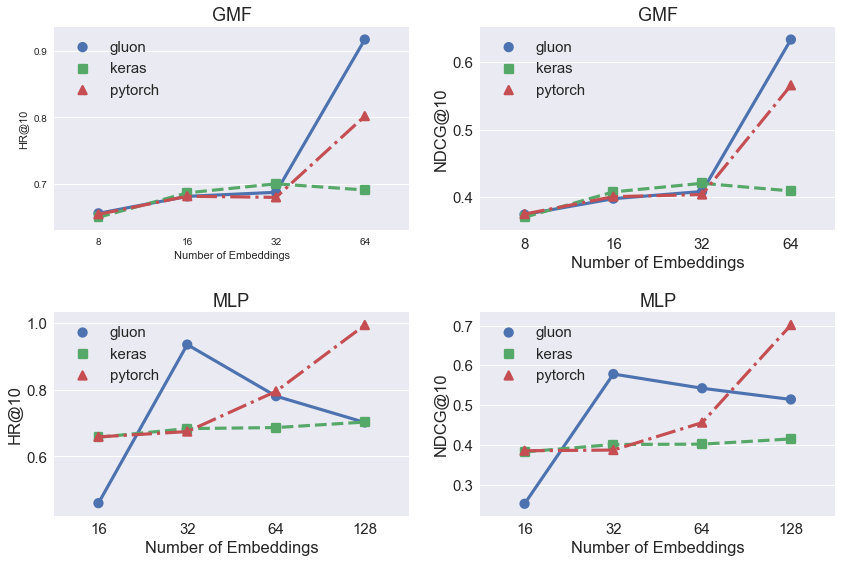

In [10]:
plot_metrics(df_gmf, df_mlp)

`Keras` is the most "stable" frame, yielding similar results across different architectures. Nonetheless, I must admit is a bit disappointing that even increasing the number of embeddings by a factor of 8 (from 8 to 64) the models fail to learn better the local relationships. I would have expected a significant increase in both `HR` and `NDCG` as embedding dimensions increase. 

`Pytorch` does actually show that behaviour for both GMF and MLP, and both `HR` and `NDCG` increase as we increase the number of embeddings. The best metrics (`best_hr=0.99`, `best_ndcg=0.70`) are significantly higher than those obtained with `Keras` and presented in the paper. 

The work in this repo represent my first contact with `Gluon`. I do like the package, and I can clearly see myself using it in the future, but there are some behaviours I do not fully understand. For example, the sudden decay in the MLP performance when going from 32 to a higher number of embeddings, or the "no learning" when using `SGD` and NeuMF. The best metrics are consistent with those obtained with `Pytorch` and therefore, significantly higher than those obtained with `Keras`. 

I am not an expert in `Keras`, `Tensorflow`, `Pytorch` and even less `Gluon`. I am perhaps more familiar with `Pytorch`, but I cannot find a good reason to explain such different results. I guess one would have to descend to teh source code of the optimizers. It is worth mentioning that there is a random element in the training phase. In every iteration we generate a set of N negative samples (N=4 in this exercise). These N negative examples will be different every time one runs the python scripts, and in every interaction. However, I don't think this justifies the different results and moreover, one would expect that any effect this sampling might have is minimised after a few epochs/iterations.  

Of course, chances are that there is a bug in the code, but that would not explain why, for example, the results between the three frames using GMF are so consistent up to 32 dim embeddings (and between `Keras` and `Pytorch` for the MLP) and then both `Gluon` and `Pytorch` increase while `Keras` remains at approximately HR@10=0.7. 

## Running Time

leaving aside the performance in terms of HR and NDCG, let's have a look to the running time for each of the 3 frames. 
The experiments here have all been run using the exact same settings. 

The training time is measured as: 

        t1 = time()
        user, item, labels = get_train_instances(train, n_items, n_neg, testNegatives)
        hist = model.fit([user, item], labels, batch_size=batch_size, epochs=1, verbose=0, shuffle=True)
        t2 = time()
        training_time = t2-t1
      
In the case of `Keras` and:

        t1 = time()
        train(model, criterion, optimizer, epoch, batch_size, use_cuda, # or cxt
            trainRatings,n_items,n_neg,testNegatives)
        t2 = time()
        training_time = t2-t1

in the cases of `Pytorch` and `Gluon`

Note that the `get_train_instances()` function is run within the `train()` function in these last two cases. Therefore, the comparison is fair. 

The results are shown below

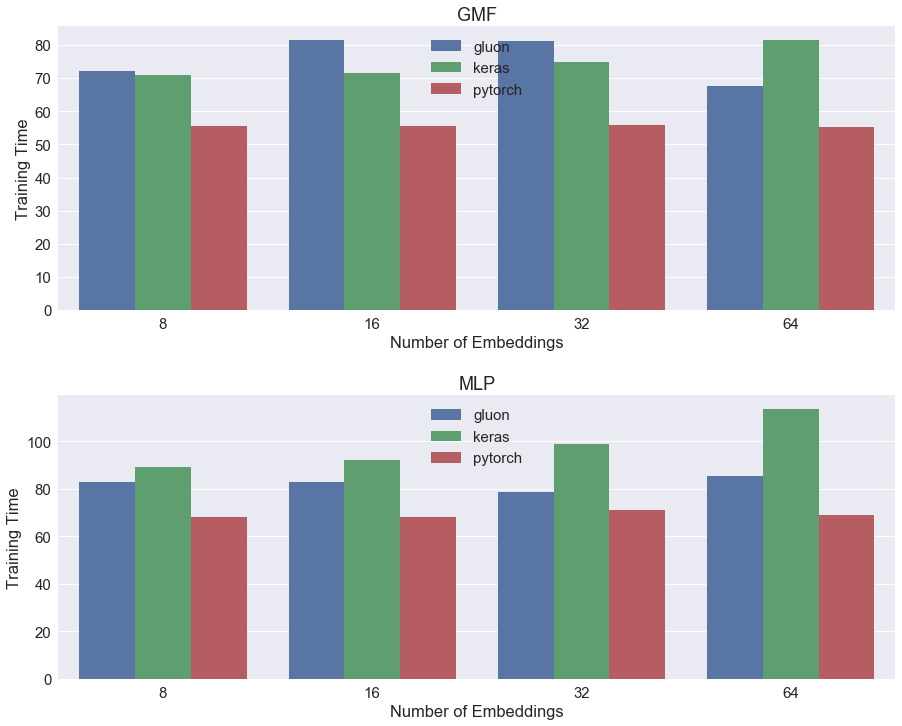

In [7]:
plot_train_time(results_df)

Consistent with my previous experience, `Pytorch` is the fastest frame. In fact, `Pytorch` seems to be inert to the number of embeddings for both GMF and MLP. `Gluon` shows a similar behaviour (albeit at slower training times) when using the MLP model. 

It is interesting to see that `Gluon` is slower than `Keras` (with the `Tensorflow` backend) when using the GMF model for a low number of embeddings. Then it gets relatively faster as the number of embedding increases, perhaps suggesting a better use of memory. 

Finally, here goes another interesting behaviour for `Gluon`. The GMF model with 64 dim embeddings runs faster than the same model with 32, 16 or 8 dim embeddings. I have reproduced this experiment a number of )times and I obtain always similar results. Again, might have to do with some optimal memory usage ( ¯\_(ツ)_/¯ ). 